In [18]:
import pandas as pd 
import numpy as np
import seaborn as sns 
from sklearn.metrics import classification_report, accuracy_score 

In [19]:
df = pd.read_csv("Youtube-Spam-Dataset.csv")
df

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",PSY - GANGNAM STYLE(?????) M/V,1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,PSY - GANGNAM STYLE(?????) M/V,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,PSY - GANGNAM STYLE(?????) M/V,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,PSY - GANGNAM STYLE(?????) M/V,1
...,...,...,...,...,...,...
1951,_2viQ_Qnc6-bMSjqyL1NKj57ROicCSJV5SwTrw-RFFA,Katie Mettam,2013-07-13T13:27:39.441000,I love this song because we sing it at Camp al...,Shakira - Waka Waka,0
1952,_2viQ_Qnc6-pY-1yR6K2FhmC5i48-WuNx5CumlHLDAI,Sabina Pearson-Smith,2013-07-13T13:14:30.021000,I love this song for two reasons: 1.it is abou...,Shakira - Waka Waka,0
1953,_2viQ_Qnc6_k_n_Bse9zVhJP8tJReZpo8uM2uZfnzDs,jeffrey jules,2013-07-13T12:09:31.188000,wow,Shakira - Waka Waka,0
1954,_2viQ_Qnc6_yBt8UGMWyg3vh0PulTqcqyQtdE7d4Fl0,Aishlin Maciel,2013-07-13T11:17:52.308000,Shakira u are so wiredo,Shakira - Waka Waka,0


In [56]:
import pandas as pd
import spacy
import random
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Step 1: Download necessary NLTK resources for cleaning
nltk.download('stopwords')
nltk.download('wordnet')

# Step 2: Load spaCy's English language model for augmentation
nlp = spacy.load('en_core_web_sm')

# Step 3: Define the data cleaning function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    text = emoji.demojize(text)  # Convert emojis to text representation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower()  # Convert to lowercase
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Lemmatization and stopword removal
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Step 4: Apply the cleaning function to the entire dataset
df['CONTENT'] = df['CONTENT'].apply(clean_text)

# Step 5: Define the synonym augmentation function using spaCy
def get_synonyms_spacy(word):
    synonyms = set()
    for syn in nltk.corpus.wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ")
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def augment_text_spacy(text, n_replacements=2):
    doc = nlp(text)
    new_words = text.split()
    random_word_list = list(set([token.text for token in doc if token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']]))
    random.shuffle(random_word_list)

    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms_spacy(random_word)
        if synonyms:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n_replacements:
            break

    return ' '.join(new_words)

# Step 6: Apply augmentation to the minority class (spam) only
df_spam = df[df['CLASS'] == 1].copy()  # Filter only spam comments
df_spam['CONTENT_augmented'] = df_spam['CONTENT'].apply(augment_text_spacy)

# Combine the original and augmented spam comments with the rest of the dataset
df_combined = pd.concat([df, df_spam[['CONTENT_augmented', 'CLASS']].rename(columns={'CONTENT_augmented': 'CONTENT'})])

# Check the updated dataset size
print("Original dataset size:", df.shape[0])
print("Augmented dataset size:", df_combined.shape[0])



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original dataset size: 1956
Augmented dataset size: 2961


In [59]:
import optuna
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Step 7: Split the augmented data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_combined['CONTENT'], df_combined['CLASS'], test_size=0.2, random_state=42)

# Step 8: TF-IDF Vectorization on the combined dataset
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Step 9: Define the objective function for Optuna hyperparameter tuning
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 0.1, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.1, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.1, 1.0)
    }

    xgb_clf = xgb.XGBClassifier(**param, use_label_encoder=False)
    xgb_clf.fit(X_train_tfidf, y_train)
    predictions = xgb_clf.predict(X_test_tfidf)
    return accuracy_score(y_test, predictions)

# Step 10: Run Optuna study to optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best trial:', study.best_trial.params)


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-07 12:28:48,754] A new study created in memory with name: no-name-ea60c1ca-7975-4d77-8919-24594edb61d8
C:\Users\HP\AppData\Local\Temp\ipykernel_34788\1430572825.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\HP\AppData\Local\Temp\ipykernel_34788\1430572825.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

Best trial: {'max_depth': 5, 'learning_rate': 0.11359356829703998, 'n_estimators': 265, 'min_child_weight': 1, 'gamma': 0.4188953630687075, 'subsample': 0.8615733390578479, 'colsample_bytree': 0.5629875414632337, 'reg_alpha': 0.938479434638916, 'reg_lambda': 0.6214766341107212}


In [60]:
# Step 11: Train the XGBoost model with the best hyperparameters from Optuna
best_params = study.best_trial.params
dtrain = xgb.DMatrix(X_train_tfidf, label=y_train)
dtest = xgb.DMatrix(X_test_tfidf, label=y_test)

bst = xgb.train(
    best_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    early_stopping_rounds=10,
    verbose_eval=True
)

# Step 12: Save the trained model and the TF-IDF vectorizer
bst.save_model('xgboost_spam_comment_classifier_optimized.json')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


[0]	train-rmse:0.45452	eval-rmse:0.45169
[1]	train-rmse:0.43392	eval-rmse:0.43109
[2]	train-rmse:0.41915	eval-rmse:0.41634
[3]	train-rmse:0.40905	eval-rmse:0.40799
[4]	train-rmse:0.39384	eval-rmse:0.39291
[5]	train-rmse:0.38302	eval-rmse:0.38231
[6]	train-rmse:0.37324	eval-rmse:0.37360
[7]	train-rmse:0.36604	eval-rmse:0.36689
[8]	train-rmse:0.35992	eval-rmse:0.36335


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:30:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[9]	train-rmse:0.35310	eval-rmse:0.35716
[10]	train-rmse:0.34654	eval-rmse:0.35121
[11]	train-rmse:0.34144	eval-rmse:0.34790
[12]	train-rmse:0.33651	eval-rmse:0.34389
[13]	train-rmse:0.33221	eval-rmse:0.34063
[14]	train-rmse:0.32939	eval-rmse:0.33861
[15]	train-rmse:0.32606	eval-rmse:0.33616
[16]	train-rmse:0.32339	eval-rmse:0.33418
[17]	train-rmse:0.31987	eval-rmse:0.33113
[18]	train-rmse:0.31667	eval-rmse:0.32802
[19]	train-rmse:0.31362	eval-rmse:0.32526
[20]	train-rmse:0.31150	eval-rmse:0.32323
[21]	train-rmse:0.30958	eval-rmse:0.32226
[22]	train-rmse:0.30736	eval-rmse:0.32054
[23]	train-rmse:0.30479	eval-rmse:0.31849
[24]	train-rmse:0.30263	eval-rmse:0.31679
[25]	train-rmse:0.30082	eval-rmse:0.31466
[26]	train-rmse:0.29915	eval-rmse:0.31293
[27]	train-rmse:0.29760	eval-rmse:0.31123
[28]	train-rmse:0.29604	eval-rmse:0.30995
[29]	train-rmse:0.29440	eval-rmse:0.30857
[30]	train-rmse:0.29292	eval-rmse:0.30714
[31]	train-rmse:0.29166	eval-rmse:0.30646
[32]	train-rmse:0.29042	eval-rmse:0

['tfidf_vectorizer.pkl']

Final Model Accuracy: 0.927487352445194
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89       185
           1       0.97      0.92      0.95       408

    accuracy                           0.93       593
   macro avg       0.91      0.93      0.92       593
weighted avg       0.93      0.93      0.93       593

Confusion Matrix:
 [[173  12]
 [ 31 377]]


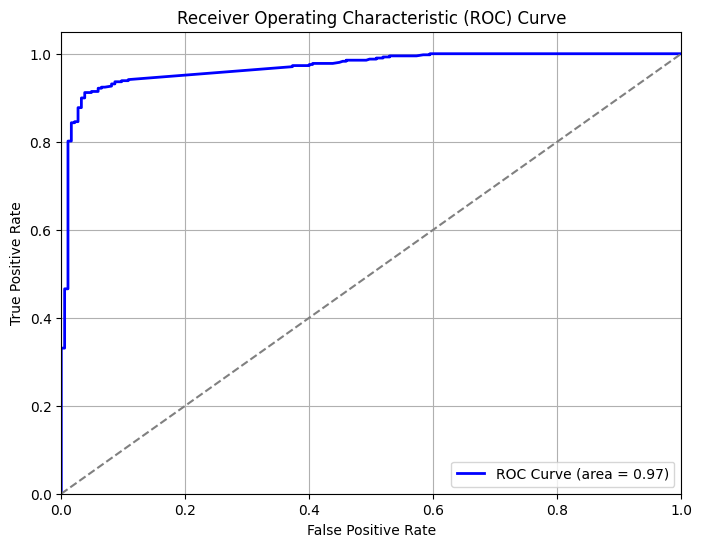

AUC Score: 0.9694621091679915


In [61]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Step 13: Make predictions on the test set
y_pred_prob = bst.predict(dtest)  # Predicted probabilities for the positive class
y_pred_binary = [1 if prob > 0.5 else 0 for prob in y_pred_prob]  # Convert probabilities to binary class labels

# Step 14: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred_binary)
classification_report_output = classification_report(y_test, y_pred_binary)
confusion_mat = confusion_matrix(y_test, y_pred_binary)

print("Final Model Accuracy:", accuracy)
print("Classification Report:\n", classification_report_output)
print("Confusion Matrix:\n", confusion_mat)

# Step 15: Plot the ROC Curve and calculate the AUC Score
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("AUC Score:", roc_auc)


In [17]:
import os

# List all files in the directory to check if the file exists
directory = 'C:/Users/HP/Desktop/Practice/'
print(os.listdir(directory))


['001.html', 'app.py', 'Model.ipynb', 'spam_comment_classifier.pkl', 'tfidf_vectorizer.pkl', 'Youtube-Spam-Dataset.csv']


In [77]:
import pandas as pd
import re
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# List of dataset files
dataset_files = [
    "Youtube01-Psy.csv",
    'Youtube02-KatyPerry.csv',
    'Youtube03-LMFAO.csv',
    'Youtube04-Eminem.csv',
    'Youtube05-Shakira.csv'
]
# Data Cleaning Function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    text = emoji.demojize(text)  # Convert emojis to text representation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower()  # Convert to lowercase
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])  # Lemmatization and stopword removal
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Dictionary to store all datasets' results
results_summary = {}
for file_name in dataset_files:
    # Load the dataset
    df = pd.read_csv(file_name)
    print(f"Processing {file_name}...")

    # Clean the text data
    df['CONTENT'] = df['CONTENT'].apply(clean_text)

    # Store the cleaned dataset for later processing
    results_summary[file_name] = df

print("Data cleaning completed for all datasets.")
      

from transformers import BertTokenizer


# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Data processing function to tokenize the text
def preprocess_data(file_name):
    df = pd.read_csv(file_name)
    df['CONTENT'] = df['CONTENT'].apply(lambda x: str(x))  # Ensure text is in string format

    # Tokenize the text using BERT's tokenizer
    tokens = tokenizer(
        df['CONTENT'].tolist(),
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return tokens, df['CLASS']

# Tokenize and prepare data for all datasets
data_tokens = {}
for file_name in dataset_files:
    tokens, labels = preprocess_data(file_name)
    data_tokens[file_name] = {'tokens': tokens, 'labels': labels}

print("Data preprocessing and tokenization completed for all datasets.")

Processing Youtube01-Psy.csv...
Processing Youtube02-KatyPerry.csv...
Processing Youtube03-LMFAO.csv...
Processing Youtube04-Eminem.csv...
Processing Youtube05-Shakira.csv...
Data cleaning completed for all datasets.


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Data preprocessing and tokenization completed for all datasets.


In [79]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Function to create DataLoader from tokens and labels
def create_dataloader(tokens, labels, batch_size=16):
    # Convert labels to tensor format
    labels_tensor = torch.tensor(labels.values, dtype=torch.long)

    # Create the TensorDataset with input_ids, attention_mask, and labels
    dataset = TensorDataset(tokens['input_ids'], tokens['attention_mask'], labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Create DataLoader for each dataset
dataloaders = {}
for file_name, data in data_tokens.items():
    dataloaders[file_name] = create_dataloader(data['tokens'], data['labels'])

print("DataLoader creation completed for all datasets.")

DataLoader creation completed for all datasets.


In [80]:
import torch
from transformers import BertForSequenceClassification, AdamW

# Initialize BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function for fine-tuning BERT
def train_bert_model(model, dataloader, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            input_ids, attention_mask, labels = [item.to(device) for item in batch]

            # Zero gradients before backward pass
            model.zero_grad()

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}')

print("Model training initiated...")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model training initiated...


In [81]:
from sklearn.metrics import classification_report, accuracy_score

# Function to evaluate BERT model on test data
def evaluate_model(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [item.to(device) for item in batch]

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).flatten()

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Generate evaluation report
    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions)
    return accuracy, report

# Evaluate the model on each dataset
for file_name, dataloader in dataloaders.items():
    accuracy, report = evaluate_model(model, dataloader)
    print(f"\nEvaluation for {file_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)

print("Model evaluation completed for all datasets.")


Evaluation for Youtube01-Psy.csv:
Accuracy: 0.5229
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.05      0.10       175
           1       0.51      0.99      0.68       175

    accuracy                           0.52       350
   macro avg       0.71      0.52      0.39       350
weighted avg       0.71      0.52      0.39       350


Evaluation for Youtube02-KatyPerry.csv:
Accuracy: 0.5257
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.09      0.15       175
           1       0.51      0.97      0.67       175

    accuracy                           0.53       350
   macro avg       0.61      0.53      0.41       350
weighted avg       0.61      0.53      0.41       350


Evaluation for Youtube03-LMFAO.csv:
Accuracy: 0.5365
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.06      0.11       202
 

In [69]:
import os

# Print the current working directory
print("Current Working Directory:", os.getcwd())


Current Working Directory: c:\Users\HP\Desktop\Practice


In [82]:
import joblib
import xgboost as xgb

# Load the saved TF-IDF vectorizer and XGBoost model
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
bst = xgb.Booster()
bst.load_model('xgboost_spam_comment_classifier_optimized.json')

# Iterate over each dataset to transform and make predictions
for file_name, df in results_summary.items():
    # Transform the cleaned text data using the existing TF-IDF vectorizer
    X_tfidf = tfidf_vectorizer.transform(df['CONTENT'])
    
    # Prepare the DMatrix for XGBoost
    dmatrix = xgb.DMatrix(X_tfidf)
    
    # Make predictions using the trained model
    y_pred_prob = bst.predict(dmatrix)
    y_pred_binary = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

    # Store predictions back in the results summary for evaluation
    results_summary[file_name]['Predicted_Class'] = y_pred_binary
    results_summary[file_name]['Predicted_Probability'] = y_pred_prob

print("Data transformation and predictions completed for all datasets.")



Data transformation and predictions completed for all datasets.


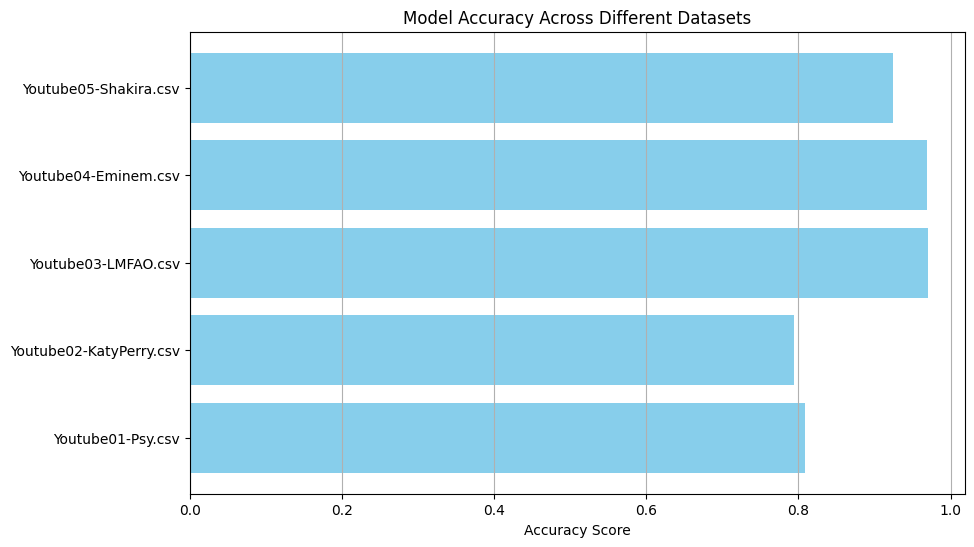

Dataset: Youtube01-Psy.csv
Accuracy: 0.81
Confusion Matrix:
 [[158  17]
 [ 50 125]]
Dataset: Youtube02-KatyPerry.csv
Accuracy: 0.79
Confusion Matrix:
 [[169   6]
 [ 66 109]]
Dataset: Youtube03-LMFAO.csv
Accuracy: 0.97
Confusion Matrix:
 [[200   2]
 [ 11 225]]
Dataset: Youtube04-Eminem.csv
Accuracy: 0.97
Confusion Matrix:
 [[202   1]
 [ 13 232]]
Dataset: Youtube05-Shakira.csv
Accuracy: 0.92
Confusion Matrix:
 [[194   2]
 [ 26 148]]


In [83]:
import matplotlib.pyplot as plt

# Plotting the accuracy scores for all datasets
dataset_names = list(evaluation_results.keys())
accuracy_scores = [evaluation_results[name]['Accuracy'] for name in dataset_names]

plt.figure(figsize=(10, 6))
plt.barh(dataset_names, accuracy_scores, color='skyblue')
plt.xlabel('Accuracy Score')
plt.title('Model Accuracy Across Different Datasets')
plt.grid(axis='x')
plt.show()

# Display summary of results for easy comparison
for file_name, metrics in evaluation_results.items():
    print(f"Dataset: {file_name}")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print("Confusion Matrix:\n", metrics['Confusion Matrix'])
    print("=" * 50)
    

